# Deep Learning - Gesture Recognition Case Study #

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Sections:

0. **Initial EDA** This section
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [43]:
#Install Few Dependencies if not available and validated versions

#!pip install Pillow
#!pip install imageio
#!pip install scikit-image
#!pip install tensorflow
#!pip install keras
print("*"*30)
print("Versions")
print("*"*30)
!pip freeze | grep 'scipy\|keras\|tensorflow'
!nvidia-smi

******************************
Versions
******************************
horovod @ file:///opt/tensorflow/horovod-source/dist/horovod-0.20.2.tar.gz
scipy==1.4.1
tensorflow @ file:///tmp/pip/tensorflow-2.3.1%2Bnv-cp36-cp36m-linux_x86_64.whl
tensorflow-addons @ file:///opt/tensorflow/tf-addons/artifacts/tensorflow_addons-0.11.2-cp36-cp36m-linux_x86_64.whl
tensorflow-datasets==3.2.1
tensorflow-estimator==2.3.0
tensorflow-metadata==0.25.0
Fri Jul 30 15:38:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==================

In [44]:
#Import the necessary Libraries

import numpy as np
import os
from timeit import default_timer as timer
import scipy
from skimage.transform import resize
import datetime
import os
from tensorflow import keras
import tensorflow as tf
import random
import glob
import cv2
import matplotlib.pyplot as plt

In [45]:
#Initialize Paths
#help(os)
#pwd = os.getcwd()
#print(pwd)

project_folder = '/datasets/Project_data'
#project_folder= '/Users/sreesree/Documents/Vinisha/MS_Sree/Real/Gesture_Recognition/Project_data'
train_image_metadata=project_folder+'/train.csv'
val_image_metadata=project_folder+'/val.csv'

We set the random seed so that the results don't vary drastically.

In [46]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

## 0. Initial EDA 

In this block, we read the folder names for training and validation. We will set the `batch_size` as part of class parameter. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. We keep on increasing the batch size until the machine throws an error.

In [47]:
train_doc = np.random.permutation(open(train_image_metadata).readlines())
val_doc = np.random.permutation(open(val_image_metadata).readlines())


In [48]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*


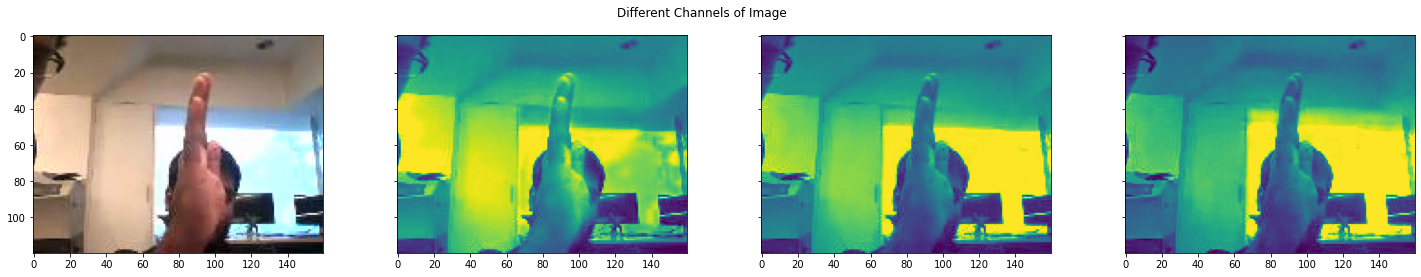

In [49]:
# run this block multiple times to look at some randomly chosen images 
rand_index = random.randint(0, len(train_doc)) # Find a random video folder 
train_path = project_folder+'/train/'+train_doc[rand_index].split(';')[0]+'/*'
print(train_path)
train_path = glob.glob(train_path) # Glob all 30 images of the folder
rand_index = random.randint(0, len(train_path))
image = cv2.imread(train_path[rand_index]) #Read a random image from the selected folder
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(25)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')
plt.show()

(120, 160, 3)


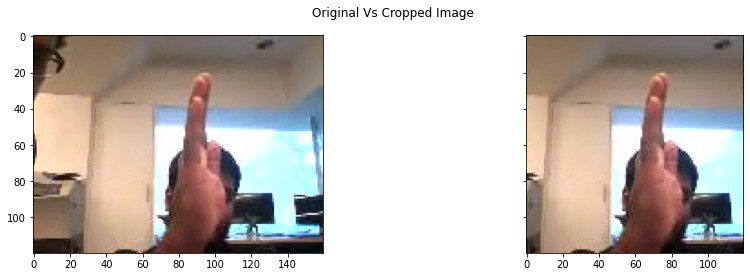

In [50]:
print(image.shape)
crop_image=image[0:120,20:140]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(crop_image)
f.suptitle('Original Vs Cropped Image')
plt.show()

In [51]:
fliplr_thumbdown_path = glob.glob('/datasets/Project_data/train/WIN_20180925_17_57_52_Pro_Thumbs_Down_new/*')
fliplr_thumbup_path= glob.glob('/datasets/Project_data/train/WIN_20180925_17_22_42_Pro_Thumbs_Up_new/*')
fliplr_rightswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180925_17_49_45_Pro_Right_Swipe_new/*')
fliplr_leftswipe_path=glob.glob('/datasets/Project_data/train/WIN_20180926_16_48_34_Pro_Left_Swipe_new/*')
crop_left_swipe = glob.glob('/datasets/Project_data/train/WIN_20180925_17_40_41_Pro_Left_Swipe_new/*')
#for path in crop_left_swipe:
#    image = cv2.imread(path) #Read a random image from the selected folder
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    f.set_figwidth(15)
#    ax1.imshow(image)
#    ax2.imshow(image[0:120,20:140])
#    f.suptitle('Original Image Vs Cropped Image')
    
    
#plt.close('all')
#plt.clf()

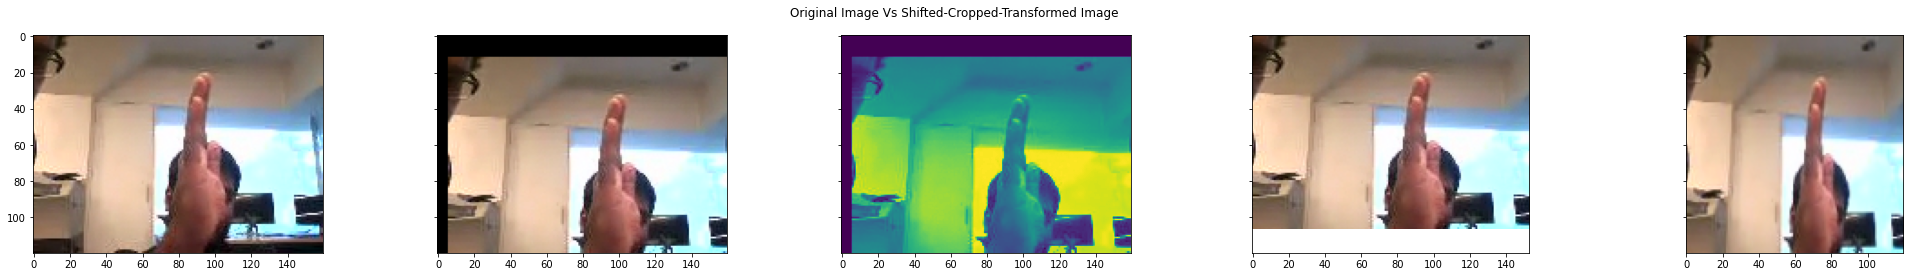

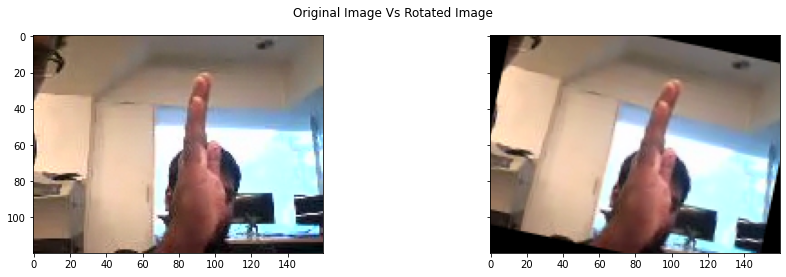

In [52]:
rows, cols = image.shape[:2]
 
# #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
#We’ll build a transformation matrix that will contain the information to transform the image. 
#For simplification, we can think of this matrix as    
    
#[[size, rotation, location], ←x-axis
#[rotation, size, location]] ←y-axis
# So default matrix will be
#[[1, 0, 0]
# [0, 1, 0]]
#That means, 100% of the size, zero rotation, and no change in the location 

# build a transformation matrix for changing location
matrix = [[1, 0, np.random.randint(-30,30)], #x 
          [0, 1, np.random.randint(-30,30)]] #y
M = np.float32(matrix)


# Apply the affine transformation using cv2.warpAffine()
shifted = cv2.warpAffine(image, M, (cols,rows))

gray = cv2.cvtColor(shifted,cv2.COLOR_RGB2GRAY)

x0, y0 = np.argwhere(gray > 0).min(axis=0)
x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  
cropped=shifted[x0:x1,y0:y1,:]


transfored_image = cv2.resize(cropped, (120,120), interpolation = cv2.INTER_AREA)


rot_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-20,20), 1)
rot_M = np.float32(rot_matrix)

# Apply the affine transformation using cv2.warpAffine()
rotated = cv2.warpAffine(image, rot_M, (cols,rows))

f, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, sharey=True)
f.set_figwidth(35)
ax1.imshow(image)
ax2.imshow(shifted)
ax3.imshow(gray)
ax4.imshow(cropped)
ax5.imshow(transfored_image)

f.suptitle('Original Image Vs Shifted-Cropped-Transformed Image')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)
ax2.imshow(rotated)
f.suptitle('Original Image Vs Rotated Image')
plt.show()


## 1. Generator
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We will experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [53]:
#Base Class for all the classes with common functionality
import abc
class BaseModel(metaclass=abc.ABCMeta):
    
    
    def __init__(self):
        # object attributes
        self.name = 'Green'
        self.timing_cb = self.TimingCallback()
        self.auc_logger = self.roc_callback()
        
        
    #initialize the path for the train and validation images
    #This will be called by each inherited class
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(train_image_metadata).readlines())
        self.val_doc = np.random.permutation(open(val_image_metadata).readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    
    #initialize the properties of each image
    #We will standardize all image using the 
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    #initalize the training parameters, this will be used by  each model to train 
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self, source_path, folder_list, augment=False):
        batch_size = self.batch_size
        #print('Source path = ', source_path)
        #print('batch size =', batch_size)
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            #print("t : ", t)
            num_batches =  len(t)//batch_size
            #print("num_batches", num_batches)
            
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
                
            
            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data_generator(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
                
                
    
    def one_batch_data_generator(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        
        #Initialize the seq length
        seq_len = remaining_seq if remaining_seq else batch_size
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_len,self.num_classes)) # batch_labels is the one hot representation of the output

        
        if (augment): 
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
            batch_data_rot = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # 360 x 360 and 120 x 160 and 
                    # the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # Crop the image which doesn't have aspect ratio of 1
                    # In the data set 120x160 will be those, we will adjust the width by trimming
                    # 20 pixels from both left and right side and making it a 120x120 image
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                        
                    #As we are shrinking the image so using Interpolation as "INTER_AREA"
                    image_resized = cv2.resize(image, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
           
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    if (augment):
                        # #https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b
                        #We’ll build a transformation matrix that will contain the information to 
                        #transform the image. 
                        #For simplification, we can think of this matrix as    
    
                        #[[size, rotation, location], ←x-axis
                        #[rotation, size, location]] ←y-axis
                        # So default matrix will be
                        #[[1, 0, 0]
                        # [0, 1, 0]]
                        #That means, 100% of the size, zero rotation, and no change in the location 

                        # build a transformation matrix
                        # We will do random location change in the range of -30 to 30 for both x and y axis
                        translation_matrix = np.array([
                                 [1, 0, np.random.randint(-30,30)], #x 
                                 [0, 1, np.random.randint(-30,30)]  #y
                        ], dtype=np.float32) 
                                                
                        rows, cols = image.shape[:2] # Height, Width
                        # Apply the affine transformation using cv2.warpAffine()
                        # cv2 needs dimensions in Width, Height formats
                        transformed = cv2.warpAffine(image, translation_matrix, (cols,rows))
                        
                        #Convert to grayscale to crop out black borders if any
                        gray = cv2.cvtColor(transformed,cv2.COLOR_RGB2GRAY)

                        # Find min and max from pixels whose intensity is not zero.
                        # Black will be zero
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=transformed[x0:x1,y0:y1,:]
                    
                        image_resized = cv2.resize(cropped, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                      
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
                        #Rotate image at an angle between -10 to 10 
                        rotate_matrix = cv2.getRotationMatrix2D((cols//2,rows//2),
                                                np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image, rotate_matrix, (cols, rows)) 
                        
                        rotated_resized = cv2.resize(rotated, (self.image_width, self.image_height), interpolation = cv2.INTER_AREA)
                        
                        batch_data_rot[folder,idx,:,:,0] = (rotated_resized[:,:,0])/255
                        batch_data_rot[folder,idx,:,:,1] = (rotated_resized[:,:,1])/255
                        batch_data_rot[folder,idx,:,:,2] = (rotated_resized[:,:,2])/255
                                               
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        #Add to the augmentated labels also if augmented is true
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_data=np.concatenate([batch_data,batch_data_rot])
            batch_labels=np.tile(batch_labels,(3,1)) # Create Label by repeating the batch_label 3 times
            

        return (batch_data, batch_labels)
    
    def train_model(self, model, augment_data = False):
        train_generator = self.generator(self.train_path, self.train_doc, augment= augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        
        if not os.path.exists(model_name):
            os.mkdir(model_name)
            
        filepath = 'model_init' + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'
        
        #HyperParameter Tuners
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
        
        callbacks_list = [checkpoint, LR, earlystop, self.timing_cb]
        
        #The `steps_per_epoch` and `validation_steps` are used by 
        #fit_generator to decide the number of next() calls it need to make.
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history   
    
    
    #Class to calculate the time taken for training each epoch
    class TimingCallback(keras.callbacks.Callback):
        def __init__(self, logs={}):
            self.logs=[]
        def on_epoch_begin(self, epoch, logs={}):
            self.starttime = timer()
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(timer()-self.starttime)
          
    
    class roc_callback(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            logs['val_auc'] = 0

        def on_epoch_end(self, epoch, logs={}):
            y_p = []
            y_v = []
            for i in range(len(val_generator)):
                x_val, y_val = val_generator[i]
                y_pred = self.model.predict(x_val)
                y_p.append(y_pred)
                y_v.append(y_val)
                y_p = np.concatenate(y_p)
                y_v = np.concatenate(y_v)
                roc_auc = roc_auc_score(y_v, y_p)
                print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
                logs['val_auc'] = roc_auc    
    
    
    @abc.abstractmethod
    def define_model(self):
        pass   
    
    

#### Plotting Function for Results ####

In [54]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 2. Model
Here we will make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. 
We will also try building a `Conv2D + RNN model`. The last layer is the softmax. We will try to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [55]:
#Common Import for Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers



### Initial Model : 0

In [56]:
class ModelConv3D_Inital(BaseModel):
    
    def define_model(self, optimizer='Adam'):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Assembling Initial Model :

In [57]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=1)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_25 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 80, 80, 32)    

Validating if this model compiles

In [58]:
conv3d_initial.train_model(conv3d_initial_model)

22/23 [===========================>..] - ETA: 1s - loss: 1.8979 - categorical_accuracy: 0.3379
Epoch 00001: val_loss improved from inf to 3.03609, saving model to model_initmodel-00001-1.89022-0.34087-3.03609--0.21000.h5
23/23 [==============================] - 40s 2s/step - loss: 1.8902 - categorical_accuracy: 0.3409 - val_loss: 3.0361 - val_categorical_accuracy: 0.2100


**Observation**  : We have now created an initial model which is compilable.


We shall now look at an optimum **initial** value for all the hyperparameters which gives us a good balance between time taken and accuracy.
- **Step 1**:  We will find the Optimum Value by analysing **Epoch Time** by, with changing few parameters linearly, and while keeping others fixed. This will be done. This will help us analyse the tradeoff of varying these values, and fix the initial values for the parameters
- **Step 2**: Next, Using these parameters we will first train for 20 epochs and see if the Training Set overlearns, which means that the model is working, when we shall move to step 3
- **Step 3** We will now look at various parameters and architectures in that order, and try to optimise it to reduce loss and increase training effeciency


### Step 1: Tradeoff Analysis
Analysing Tradeoff between Image Resolution, Number of Images and Batch Size

**Approach** : We will first Decrease the Batch Parameters,then Increase the Resolution of the Images, and then play around with the Frames. 
At each step, We will analyse the time for each Epoch and Total time, to see if this makes a difference to the training time.  Using this we will try to guestimate the parameters we should start with

We will use limited epochs, for the training as that is not important for this experiment

In [59]:
#Baseline
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))


Epoch 1/3
22/23 [===========================>..] - ETA: 1s - loss: 1.9231 - categorical_accuracy: 0.3712
Epoch 00001: val_loss improved from inf to 2.35595, saving model to model_initmodel-00001-1.93161-0.36953-2.35595--0.16000.h5
23/23 [==============================] - 35s 2s/step - loss: 1.9316 - categorical_accuracy: 0.3695 - val_loss: 2.3559 - val_categorical_accuracy: 0.1600
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.2143 - categorical_accuracy: 0.5460
Epoch 00002: val_loss did not improve from 2.35595
23/23 [==============================] - 35s 2s/step - loss: 1.2143 - categorical_accuracy: 0.5460 - val_loss: 3.6923 - val_categorical_accuracy: 0.1600
Epoch 3/3
22/23 [===========================>..] - ETA: 1s - loss: 0.9198 - categorical_accuracy: 0.6576
Epoch 00003: val_loss did not improve from 2.35595
23/23 [==============================] - 34s 1s/step - loss: 0.9166 - categorical_accuracy: 0.6591 - val_loss: 4.5149 - val_categorical_accuracy: 0.170

In [60]:
#Reduce Batch Size from 30 to 20
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=100, image_width=100)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8621 - categorical_accuracy: 0.3514
Epoch 00001: val_loss improved from inf to 2.86056, saving model to model_initmodel-00001-1.86208-0.35143-2.86056--0.21000.h5
34/34 [==============================] - 36s 1s/step - loss: 1.8621 - categorical_accuracy: 0.3514 - val_loss: 2.8606 - val_categorical_accuracy: 0.2100
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.4427 - categorical_accuracy: 0.4691
Epoch 00002: val_loss did not improve from 2.86056
34/34 [==============================] - 36s 1s/step - loss: 1.4427 - categorical_accuracy: 0.4691 - val_loss: 4.7550 - val_categorical_accuracy: 0.1900
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.2730 - categorical_accuracy: 0.5475
Epoch 00003: val_loss did not improve from 2.86056
34/34 [==============================] - 35s 1s/step - loss: 1.2730 - categorical_accuracy: 0.5475 - val_loss: 6.6965 - val_categorical_accuracy: 0.210

In [61]:
#Reduce Image Size from 100 to 84
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=84, image_width=84)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 2.1047 - categorical_accuracy: 0.3469
Epoch 00001: val_loss improved from inf to 2.08696, saving model to model_initmodel-00001-2.10465-0.34691-2.08696--0.16000.h5
34/34 [==============================] - 33s 981ms/step - loss: 2.1047 - categorical_accuracy: 0.3469 - val_loss: 2.0870 - val_categorical_accuracy: 0.1600
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3321 - categorical_accuracy: 0.5309
Epoch 00002: val_loss did not improve from 2.08696
34/34 [==============================] - 34s 1s/step - loss: 1.3321 - categorical_accuracy: 0.5309 - val_loss: 2.6235 - val_categorical_accuracy: 0.1500
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.1390 - categorical_accuracy: 0.5867
Epoch 00003: val_loss did not improve from 2.08696
34/34 [==============================] - 33s 982ms/step - loss: 1.1390 - categorical_accuracy: 0.5867 - val_loss: 3.0993 - val_categorical_accuracy:

In [62]:
#Reduce Image Size from 100 to 84 and Sample all data
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=84, image_width=84)
conv3d_initial.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.9515 - categorical_accuracy: 0.3107
Epoch 00001: val_loss improved from inf to 1.89241, saving model to model_initmodel-00001-1.95154-0.31071-1.89241--0.16000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.9515 - categorical_accuracy: 0.3107 - val_loss: 1.8924 - val_categorical_accuracy: 0.1600
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.4191 - categorical_accuracy: 0.4827
Epoch 00002: val_loss did not improve from 1.89241
34/34 [==============================] - 61s 2s/step - loss: 1.4191 - categorical_accuracy: 0.4827 - val_loss: 2.4435 - val_categorical_accuracy: 0.2500
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.2171 - categorical_accuracy: 0.5189
Epoch 00003: val_loss did not improve from 1.89241
34/34 [==============================] - 60s 2s/step - loss: 1.2171 - categorical_accuracy: 0.5189 - val_loss: 4.3305 - val_categorical_accuracy: 0.180

In [63]:
#Increase Image Resolution to 160
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
33/34 [============================>.] - ETA: 1s - loss: 1.9259 - categorical_accuracy: 0.3788
Epoch 00001: val_loss improved from inf to 7.73936, saving model to model_initmodel-00001-1.92892-0.37858-7.73936--0.16000.h5
34/34 [==============================] - 41s 1s/step - loss: 1.9289 - categorical_accuracy: 0.3786 - val_loss: 7.7394 - val_categorical_accuracy: 0.1600
Epoch 2/3
33/34 [============================>.] - ETA: 1s - loss: 1.1977 - categorical_accuracy: 0.5561
Epoch 00002: val_loss improved from 7.73936 to 7.47727, saving model to model_initmodel-00002-1.19969-0.55656-7.47727--0.14000.h5
34/34 [==============================] - 40s 1s/step - loss: 1.1997 - categorical_accuracy: 0.5566 - val_loss: 7.4773 - val_categorical_accuracy: 0.1400
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.0316 - categorical_accuracy: 0.6244
Epoch 00003: val_loss did not improve from 7.47727
34/34 [==============================] - 40s 1s/step - loss: 1.0316 - ca

In [64]:
#Retain Image size 160 & Increase Frames to 30
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.8216 - categorical_accuracy: 0.3514
Epoch 00001: val_loss improved from inf to 4.25360, saving model to model_initmodel-00001-1.82165-0.35143-4.25360--0.21000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.8216 - categorical_accuracy: 0.3514 - val_loss: 4.2536 - val_categorical_accuracy: 0.2100
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.4422 - categorical_accuracy: 0.4827
Epoch 00002: val_loss did not improve from 4.25360
34/34 [==============================] - 72s 2s/step - loss: 1.4422 - categorical_accuracy: 0.4827 - val_loss: 7.3746 - val_categorical_accuracy: 0.2100
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.2894 - categorical_accuracy: 0.5128
Epoch 00003: val_loss did not improve from 4.25360
34/34 [==============================] - 73s 2s/step - loss: 1.2894 - categorical_accuracy: 0.5128 - val_loss: 11.3928 - val_categorical_accuracy: 0.20

In [67]:
#Reatain Image size 160 and Reduce Batch Size and Augmentatation is True
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
#Reduce the batch size as no of Images have tripled
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=10,num_epochs=3)
conv3d_initial_model = conv3d_initial.define_model()
#conv3d_initial_model.summary()
conv3d_initial.train_model(conv3d_initial_model, augment_data = True)
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))

Epoch 1/3
67/67 [==============================] - ETA: 0s - loss: 1.7848 - categorical_accuracy: 0.3866
Epoch 00001: val_loss improved from inf to 7.16360, saving model to model_initmodel-00001-1.78483-0.38663-7.16360--0.21000.h5
67/67 [==============================] - 131s 2s/step - loss: 1.7848 - categorical_accuracy: 0.3866 - val_loss: 7.1636 - val_categorical_accuracy: 0.2100
Epoch 2/3
67/67 [==============================] - ETA: 0s - loss: 1.2145 - categorical_accuracy: 0.5540
Epoch 00002: val_loss improved from 7.16360 to 4.48283, saving model to model_initmodel-00002-1.21449-0.55405-4.48283--0.29000.h5
67/67 [==============================] - 131s 2s/step - loss: 1.2145 - categorical_accuracy: 0.5540 - val_loss: 4.4828 - val_categorical_accuracy: 0.2900
Epoch 3/3
67/67 [==============================] - ETA: 0s - loss: 0.9496 - categorical_accuracy: 0.6526
Epoch 00003: val_loss improved from 4.48283 to 4.46584, saving model to model_initmodel-00003-0.94956-0.65259-4.46584--0.

**Observation**

- The batch size didnt significantly impact the performance - We can stick to **40** for now, so that we have maximum parallelism
- The resolution of the image impacts the training time. We can stick to the medium-high resolution of **160*160** 
- Augmentation is taking 3X the time as compared to non augmented images. We will initially train without Augmentation and then expand to include augmentation
- The No of Frames parameter is also directly impacting time to train. This is understandable. Considering we have 30 images, we can now sample 2/3 **20 Frames** in each video, which will be enough to capture the variation

#### Step 2: 
We will now train the model with the above parameters for 10 epochs, and see if the model is learning. We expect this model to overfit, and if that happens then we are on the right track. 
We will also try to augment the images and validate the same over a few epochs
If the assumptions are validated, then we will run this model over a 20 epochs and establish our baseline model which we improve over the next iterations

In [68]:
conv3d_initial = ModelConv3D_Inital()
conv3d_initial.initialize_path(project_folder)
conv3d_initial.initialize_image_properties(image_height=160, image_width=160)
conv3d_initial.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=10)
conv3d_initial_model = conv3d_initial.define_model()
conv3d_initial_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_60 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_60 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_61 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 10, 80, 80, 32)  

In [69]:
print("Total Params:", conv3d_initial_model.count_params())
history_model_initial = conv3d_initial.train_model(conv3d_initial_model)

Total Params: 1736389
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.8541 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 1.67461, saving model to model_initmodel-00001-1.85409-0.39065-1.67461--0.21000.h5
17/17 [==============================] - 47s 3s/step - loss: 1.8541 - categorical_accuracy: 0.3906 - val_loss: 1.6746 - val_categorical_accuracy: 0.2100
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.1230 - categorical_accuracy: 0.5656
Epoch 00002: val_loss did not improve from 1.67461
17/17 [==============================] - 47s 3s/step - loss: 1.1230 - categorical_accuracy: 0.5656 - val_loss: 3.6127 - val_categorical_accuracy: 0.2300
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.7584 - categorical_accuracy: 0.6968
Epoch 00003: val_loss did not improve from 1.67461
17/17 [==============================] - 47s 3s/step - loss: 0.7584 - categorical_accuracy: 0.6968 - val_loss: 4.7216 - val_ca

Per Epoch time  [48.720631688134745, 47.862508872989565, 46.96260104305111, 48.123212391044945, 48.44232309493236, 46.49499124288559, 46.97988271899521, 47.807024023961276, 46.27072349493392, 48.07002721983008]
Total Time: 475.7339257907588


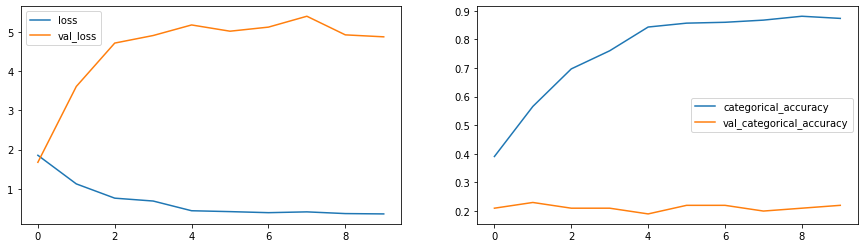

In [71]:
print("Per Epoch time  {}".format(conv3d_initial.timing_cb.logs))
print("Total Time: {}".format(sum(conv3d_initial.timing_cb.logs)))
plot(history_model_initial)

**Observation**
- The model is clearly learning, and also clearly overfitting. This the intended outcome.

### Step 3: 
We will now train the model with the above parameters for larger epochs and establish the baseline. As we have observed the model was overfitting, so we will add a droput layer in our baseline
Post that we will improve on our baseline by using various experiments


#### Model 1 ####
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 15
- Dropouts - 0.25
- Dense Neurons - 128,64

In [74]:
#Baseline Model Definition

class ModelConv3D1(BaseModel):
    
    def define_model(self, optimizer='Adam'):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [75]:
#Baseline Model
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_64 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_64 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_65 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 10, 80, 80, 32)  

In [76]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.3537 - categorical_accuracy: 0.5023
Epoch 00001: val_loss improved from inf to 1.98910, saving model to model_initmodel-00001-1.35368-0.50226-1.98910--0.21000.h5
17/17 [==============================] - 47s 3s/step - loss: 1.3537 - categorical_accuracy: 0.5023 - val_loss: 1.9891 - val_categorical_accuracy: 0.2100
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.5478 - categorical_accuracy: 0.8100
Epoch 00002: val_loss did not improve from 1.98910
17/17 [==============================] - 47s 3s/step - loss: 0.5478 - categorical_accuracy: 0.8100 - val_loss: 3.2884 - val_categorical_accuracy: 0.2300
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.3246 - categorical_accuracy: 0.8989
Epoch 00003: val_loss did not improve from 1.98910
17/17 [==============================] - 46s 3s/step - loss: 0.3246 - categorical_accuracy: 0.8989 - val_loss: 4.6358 - val_ca

Per Epoch time  [48.644774741027504, 47.46108501707204, 46.67656543897465, 47.74904403393157, 47.90786797506735, 45.95863923896104, 48.290520327864215, 47.351349334931, 46.468634717166424, 48.53164465283044, 47.87272144295275]
Total Time: 522.912846920779


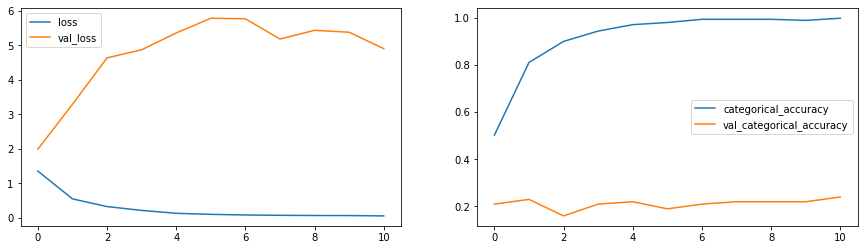

In [77]:
print("Per Epoch time  {}".format(conv_3d1.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d1.timing_cb.logs)))
plot(history_model1)

**Observation** 
- The baseline model is established. Clearly the model is overfitting, 
- We have an accuracy of 0.58 and validation loss of 1.98

#### Model 2 ####
We will try to add more dropouts and dense layers to reduce overfitting
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.5
- Dense Neurons - 256

In [79]:
class ModelConv3D2(BaseModel):
    
    def define_model(self, optimizer='Adam', dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, (3,3,3), padding='same',
                        input_shape=(self.frames_to_sample, self.image_height, self.image_width, self.channels)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        #optimizer = optimizers.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [80]:
conv_3d2=ModelConv3D2()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=128,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_68 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_68 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_68 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_69 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 10, 80, 80, 32)  

In [81]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model)

Total Params: 1745221
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8445 - categorical_accuracy: 0.4087
Epoch 00001: val_loss improved from inf to 2.47595, saving model to model_initmodel-00001-1.84451-0.40875-2.47595--0.16000.h5
34/34 [==============================] - 50s 1s/step - loss: 1.8445 - categorical_accuracy: 0.4087 - val_loss: 2.4760 - val_categorical_accuracy: 0.1600
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.1977 - categorical_accuracy: 0.5818
Epoch 00002: val_loss did not improve from 2.47595
34/34 [==============================] - 48s 1s/step - loss: 1.2055 - categorical_accuracy: 0.5792 - val_loss: 5.5335 - val_categorical_accuracy: 0.2100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9288 - categorical_accuracy: 0.6802
Epoch 00003: val_loss did not improve from 2.47595
34/34 [==============================] - 49s 1s/step - loss: 0.9288 - categorical_accuracy: 0.6802 - val_loss: 7.7241 - val_ca

Per Epoch time  [48.644774741027504, 47.46108501707204, 46.67656543897465, 47.74904403393157, 47.90786797506735, 45.95863923896104, 48.290520327864215, 47.351349334931, 46.468634717166424, 48.53164465283044, 47.87272144295275]
Total Time: 522.912846920779


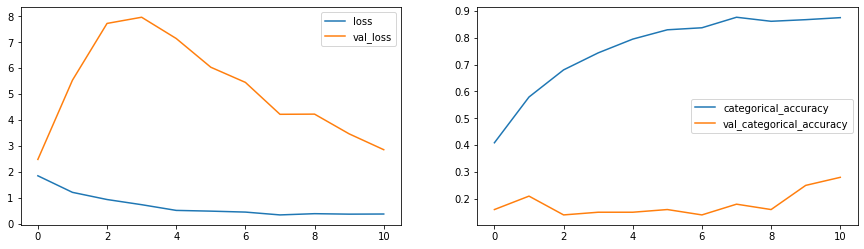

In [83]:
print("Per Epoch time  {}".format(conv_3d1.timing_cb.logs))
print("Total Time: {}".format(sum(conv_3d1.timing_cb.logs)))
plot(history_model2)

**Observation**:
  - The model generalized pretty much due to the combination of droputs and fully connected layers
  - Validation loss is at 0.31 and Accuracy is at 0.97 which is much better than the previous model

#### Model 3 ####
We will try to increase the size of the convolution filter to see if there is a a better generalization
- Image - 160*160
- Batch Size - 40
- Num of Epochs - 25
- Dropouts - 0.5
- Dense Neurons - 256

# LSTM Model

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16

In [19]:
#Baseline Model Definition

class ModelLSTM1(BaseModel):
    
    #We will also add a standard filtersize and dropout to generalize
    def define_model(self, optimiser='Adam'):
        
        base_model = VGG16(include_top=False, weights='imagenet', 
                         input_shape=(self.image_height,self.image_width,self.channels))  
                          
        x = base_model.output
        x = Flatten()(x)

        features = Dense(64, activation='relu')(x)
        conv_model = Model(inputs=base_model.input, outputs=features)
    
        for layer in base_model.layers:
            layer.trainable = False
        
        model = Sequential()
        model.add(TimeDistributed(conv_model, 
                    input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(GRU(32, return_sequences=True))
        model.add(GRU(16))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(5, activation='softmax'))

        #optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
#Baseline
LSTM_initial = ModelLSTM1()
LSTM_initial.initialize_path(project_folder)
LSTM_initial.initialize_image_properties(image_height=100, image_width=100)
LSTM_initial.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
LSTM_initial_model = LSTM_initial.define_model()
LSTM_initial_model.summary()
LSTM_initial.train_model(LSTM_initial_model)
print("Per Epoch time  {}".format(LSTM_initial.timing_cb.logs))
print("Total Time: {}".format(sum(LSTM_initial.timing_cb.logs)))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 64)            15009664  
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 32)            9408      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 15,021,653
Trainable params: 306,965
Non-trainable params: 14,714,688
____________________________________